In [2]:
import sys
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error

sys.path.append("..")
from timefusion.utils import metrics

# Electricity

In [3]:
# Import data
train_data = pd.read_csv("../datasets/electricity/train.csv", index_col="date")
val_data = pd.read_csv("../datasets/electricity/val.csv", index_col="date")
test_data = pd.read_csv("../datasets/electricity/test.csv", index_col="date")

# Normalize data standard deviation
stds = train_data.std()
train_data /= stds
val_data /= stds
test_data /= stds

# Some parameters
prediction_length = 24

In [32]:
indices = list(range(val_data.shape[0] - prediction_length, val_data.shape[0] - prediction_length - 14*prediction_length, - prediction_length))
realisations = torch.tensor(np.array([val_data.values[idx:idx+prediction_length] for idx in indices])).permute((0,2,1))

# Find best lag order using validation data
for i in range(9):
    maxlags = 2**i
    model = VAR(train_data, freq="H")
    results = model.fit(maxlags=maxlags)

    # Test on validation data
    samples = []
    for idx in indices:
        predictions = results.forecast(val_data.values[idx-maxlags:idx], prediction_length)
        samples.append(torch.tensor(predictions).T)
    samples = torch.stack(samples)

    # Compute metrics
    mse = mean_squared_error(realisations.flatten(), samples.flatten())
    mae = mean_absolute_error(realisations.flatten(), samples.flatten())
    mdae = median_absolute_error(realisations.flatten(), samples.flatten())
    crps_sum = np.mean([metrics.crps_sum(samples[i].unsqueeze(0), realisations[i]) for i in range(realisations.shape[0])])
    variogram_score = np.mean([metrics.variogram_score(samples[i].unsqueeze(0), realisations[i], weights="local", window_size=2) for i in range(realisations.shape[0])])
    print(maxlags, mse, mae, mdae, crps_sum, variogram_score)

1 0.42809645346403336 0.5037136108854312 0.4162448194311368 78.30510365282612 0.12931775661936545
2 0.33741997265193774 0.4326887075433596 0.34147022973514995 48.611834718694695 0.11728394631300333
4 0.3348306441558083 0.4316285149086197 0.33842160591304704 52.447653252223084 0.11276774423632414
8 0.29316377267101074 0.3903048875443268 0.29005621017771865 28.269334931856907 0.10805193984487983
16 0.30094982988254454 0.391862092974616 0.2855206266153585 39.21508338970704 0.10772115789238683
32 0.43851576342307963 0.48588394598339224 0.36437633821310755 30.968111362522855 0.147259184528114
64 320.69901703605007 13.30320995427674 10.206449440930175 1044.2206077181154 11.464323262676938


In [5]:
# Test performance
indices = list(range(test_data.shape[0] - prediction_length, test_data.shape[0] - prediction_length - 14*prediction_length, - prediction_length))
realisations = torch.tensor(np.array([test_data.values[idx:idx+prediction_length] for idx in indices])).permute((0,2,1))

maxlags = 16
model = VAR(train_data, freq="H")
results = model.fit(maxlags=maxlags)

samples = []
for idx in indices:
    predictions = results.forecast(test_data.values[idx-maxlags:idx], prediction_length)
    samples.append(torch.tensor(predictions).T)
samples = torch.stack(samples)

# Compute metrics
mse = mean_squared_error(realisations.flatten(), samples.flatten())
mae = mean_absolute_error(realisations.flatten(), samples.flatten())
mdae = median_absolute_error(realisations.flatten(), samples.flatten())
crps_sum = np.mean([metrics.crps_sum(samples[i].unsqueeze(0), realisations[i]) for i in range(realisations.shape[0])])
variogram_score = np.mean([metrics.variogram_score(samples[i].unsqueeze(0), realisations[i], weights="local", window_size=2) for i in range(realisations.shape[0])])
print(maxlags, mse, mae, mdae, crps_sum, variogram_score)


16 0.2370868538876482 0.3698434929681436 0.2941041310678142 39.73870525246162 0.09652434138596963


# Exchange

In [ ]:
# Import data
train_data = pd.read_csv("../../datasets/exchange/train.csv")
val_data = pd.read_csv("../../datasets/exchange/val.csv")
test_data = pd.read_csv("../../datasets/exchange/test.csv")

# Normalize the signal power of each column
stds = train_data.std()
train_data /= stds
val_data /= stds
test_data /= stds

In [ ]:
indices = list(range(val_data.shape[0] - prediction_length, val_data.shape[0] - prediction_length - 14*prediction_length, - prediction_length))
realisations = torch.tensor(np.array([val_data.values[idx:idx+prediction_length] for idx in indices])).permute((0,2,1))

# Find best lag order using validation data
for i in range(9):
    maxlags = 2**i
    model = VAR(train_data, freq="H")
    results = model.fit(maxlags=maxlags)

    # Test on validation data
    samples = []
    for idx in indices:
        predictions = results.forecast(val_data.values[idx-maxlags:idx], prediction_length)
        samples.append(torch.tensor(predictions).T)
    samples = torch.stack(samples)

    # Compute metrics
    mse = mean_squared_error(realisations.flatten(), samples.flatten())
    mae = mean_absolute_error(realisations.flatten(), samples.flatten())
    mdae = median_absolute_error(realisations.flatten(), samples.flatten())
    crps_sum = np.mean([metrics.crps_sum(samples[i].unsqueeze(0), realisations[i]) for i in range(realisations.shape[0])])
    variogram_score = np.mean([metrics.variogram_score(samples[i].unsqueeze(0), realisations[i], weights="local", window_size=2) for i in range(realisations.shape[0])])
    print(maxlags, mse, mae, mdae, crps_sum, variogram_score)

# Solar

In [15]:
predictions = results.forecast(test_data.values[-maxlags:], prediction_length)

In [14]:
results.k_ar

20

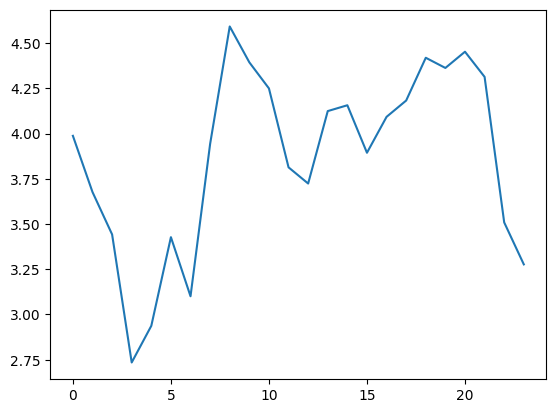

In [17]:
plt.plot(predictions[:,1])

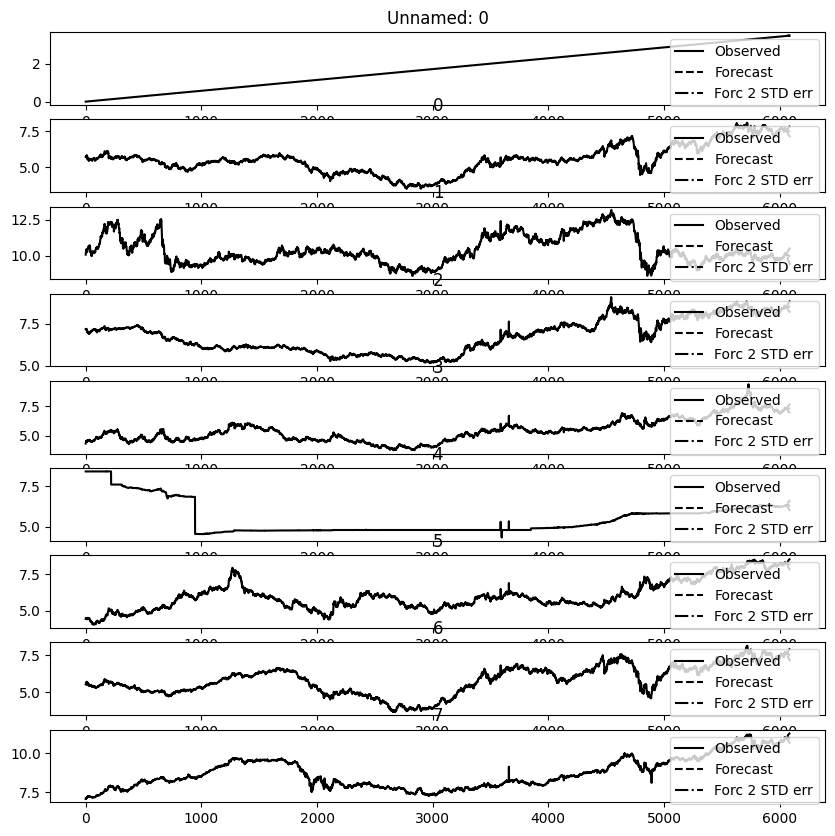

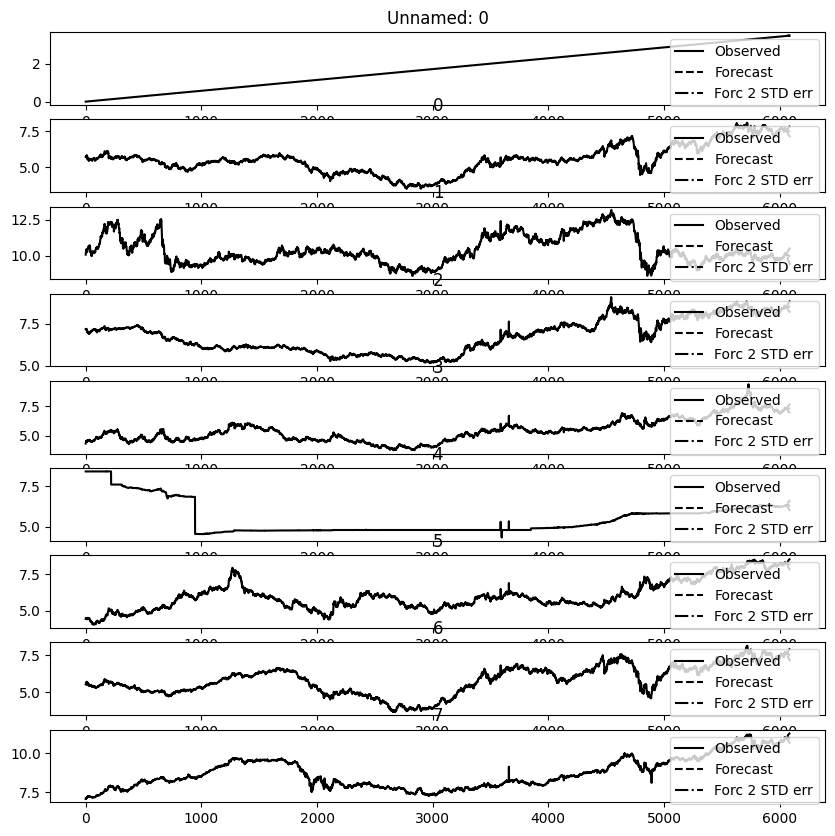

In [4]:
results.plot_forecast(24)

In [14]:
samples = results.irf_resim(repl = 128, steps = 30)

In [7]:
k = results.irf_resim()

In [15]:
samples.shape

(128, 31, 9, 9)

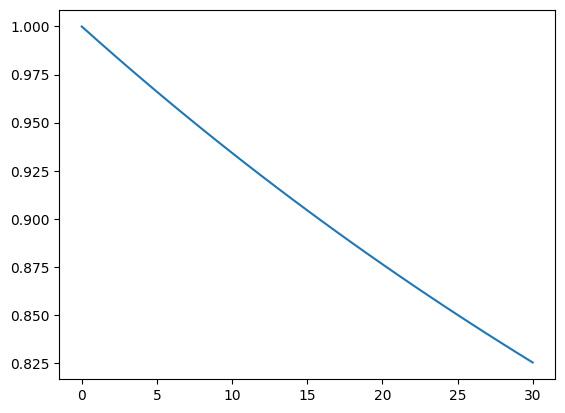

In [19]:
plt.plot(samples[1, :, 1, 1])

In [9]:
k.shape

(1000, 11, 9, 9)

In [3]:
# Import data
train_data = pd.read_csv("../datasets/electricity/train.csv").set_index("date")
val_data = pd.read_csv("../datasets/electricity/val.csv").set_index("date")
test_data = pd.read_csv("../datasets/electricity/test.csv").set_index("date")

# Normalize data standard deviation
stds = train_data.std()
train_data /= stds
val_data /= stds
test_data /= stds

In [4]:
# Fit a VAR model
model = VAR(train_data)
results = model.fit()

/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/classical_models/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


In [5]:
k = results.irf_resim()

In [31]:
predictions = results.forecast(val_data[:-30].values,24)

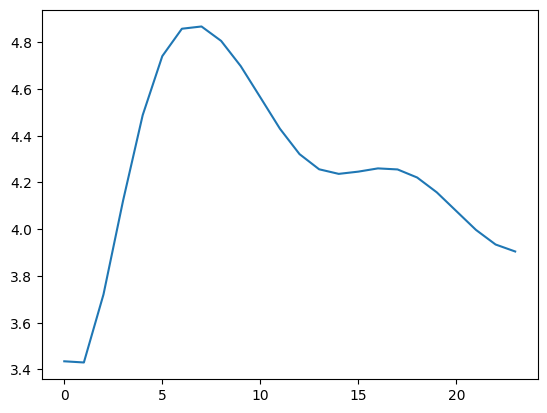

In [33]:
plt.plot(predictions[:,1])

In [ ]:
import pandas as pd
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.var_model import VARResults

# Load the dataset
data = pd.read_csv('your_dataset.csv')  # Replace 'your_dataset.csv' with the path to your dataset

# Preprocess the data (if required)
# Ensure that your dataset is in the proper format for VAR modeling

# Split the data into training and testing sets
train_data = data.iloc[:-12, :]  # Use first n-12 observations for training
test_data = data.iloc[-12:, :]  # Use last 12 observations for testing

# Train the VAR model
model = VAR(train_data)
results = model.fit()

# Forecasting
lag_order = results.k_ar
forecast_input = train_data.values[-lag_order:]
forecast = results.forecast(y=forecast_input, steps=12)  # Forecasting for the next 12 periods

# Print the forecasted values
print(forecast)

# Evaluate the model (if applicable)
# Perform any necessary evaluation of the model using evaluation metrics or visualizations

# Save the model (optional)
# results.save('your_model.pkl')

# Load the model (optional)
# loaded_model = VARResults.load('your_model.pkl')
